# <u><center>Twitter Sentiment Analysis : US Airline</center></u>

#### **Importing requires libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords') 
from nltk.tokenize import word_tokenize
nltk.download('punkt')


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

#### **Reading the training and testing csv files**

In [4]:
df_training = pd.read_csv("twitter_x_y_train.csv")
df_testing = pd.read_csv("twitter_x_test.csv")
df_training.shape, df_testing.shape

((10980, 12), (3660, 11))

In [5]:
df_training.head(2)

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)


In [6]:
feat_with_null = [feature for feature in df_training.columns if df_training[feature].isnull().sum() > 0]
feat_with_null

['airline_sentiment_gold',
 'negativereason_gold',
 'tweet_coord',
 'tweet_location',
 'user_timezone']

In [7]:
df_training.columns

Index(['tweet_id', 'airline_sentiment', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
df_training.airline_sentiment.value_counts()

negative    6851
neutral     2327
positive    1802
Name: airline_sentiment, dtype: int64

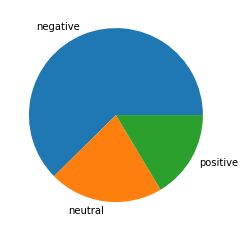

In [9]:
plt.pie(df_training.airline_sentiment.value_counts().values, labels = df_training.airline_sentiment.value_counts().index)
plt.show()

negative    6851
neutral     2327
positive    1802
Name: airline_sentiment, dtype: int64

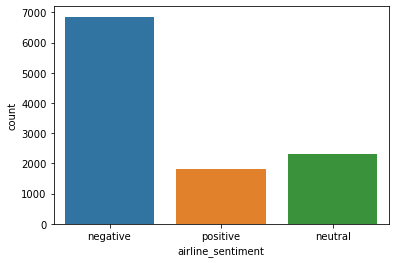

In [10]:
sns.countplot(x = 'airline_sentiment', data = df_training)
df_training['airline_sentiment'].value_counts()

#### **Exracting the tweets and sentiments of training data**

In [11]:
df_train = df_training[['text', 'airline_sentiment']]
df_train.head()

,text,airline_sentiment
0,"@SouthwestAir I am scheduled for the morning, ...",negative
1,@SouthwestAir seeing your workers time in and ...,positive
2,@united Flew ORD to Miami and back and had gr...,positive
3,@SouthwestAir @dultch97 that's horse radish 😤🐴,negative
4,@united so our flight into ORD was delayed bec...,negative


## <u><center>Text Pre-processing</center></u>

#### tokenization -> lowering -> stopwords and punctuation removal -> lemmatization

In [12]:
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

# object for lemmatizer
lemmatizer = WordNetLemmatizer()

#removing 'not' from stop words

In [13]:
df_train.head()

,text,airline_sentiment
0,"@SouthwestAir I am scheduled for the morning, ...",negative
1,@SouthwestAir seeing your workers time in and ...,positive
2,@united Flew ORD to Miami and back and had gr...,positive
3,@SouthwestAir @dultch97 that's horse radish 😤🐴,negative
4,@united so our flight into ORD was delayed bec...,negative


### Sample Cleaning of one tweet

In [14]:
words = word_tokenize("@SouthwestAir @dultch97 that's horse radish 😤🐴")
print(words)
print()
output_words=[]
for w in words:
    if w.lower() not in stops and w.lower().isalpha():
            # applying lemmatizer 
        clean_word = lemmatizer.lemmatize(w)
        output_words.append(clean_word.lower())
print(output_words)
print()
" ".join(output_words) 

['@', 'SouthwestAir', '@', 'dultch97', 'that', "'s", 'horse', 'radish', '😤🐴']

['southwestair', 'horse', 'radish']



'southwestair horse radish'

### Cleaning all Tweets

In [15]:
# function to clean each tweets
def clean_tweet(text):
    words = word_tokenize(text)
    # Created empty a list to store the clean tweet words
    output_words = []
    # traversing through each word, Ignoring the stopwords, punctuations, Checking whether word contains only alphabets?
    for w in words:
        if w.lower() not in stops and w.lower().isalpha():
            # applying lemmatizer 
            clean_word = lemmatizer.lemmatize(w)
            output_words.append(clean_word.lower())
            
    #clean_sentence = [" ".join(w) for w in output_words]
    clean_sentence = " ".join(output_words) 
    
    return clean_sentence

In [16]:
df_train['clean_text'] = pd.DataFrame(df_train['text'].apply(clean_tweet))
df_train.head(2)

,text,airline_sentiment,clean_text
0,"@SouthwestAir I am scheduled for the morning, ...",negative,southwestair scheduled morning day fact yes su...
1,@SouthwestAir seeing your workers time in and ...,positive,southwestair seeing worker time time going bey...


In [17]:
df_train.drop(['text'], axis = 1, inplace = True)
df_train.head(2)

,airline_sentiment,clean_text
0,negative,southwestair scheduled morning day fact yes su...
1,positive,southwestair seeing worker time time going bey...


In [18]:
df_test = df_testing[['text']]
df_test.head(2)

,text
0,@AmericanAir In car gng to DFW. Pulled over 1h...
1,"@AmericanAir after all, the plane didn’t land ..."


In [19]:
df_test['clean_text'] = pd.DataFrame(df_test['text'].apply(clean_tweet))
df_test.drop(['text'], axis = 1, inplace = True)
df_test.head(2)

,clean_text
0,americanair car gng dfw pulled ago icy road aa...
1,americanair plane land identical worse conditi...


## <u><center>Feature Extraction</center></u>
#### **Tfidf Vectorizer**

In [20]:
tfid_vec = TfidfVectorizer(max_features=1000)

x_train1 = tfid_vec.fit_transform(df_train.clean_text)
y_train1 = df_train['airline_sentiment']

x_test1 = tfid_vec.transform(df_test['clean_text'])

# summarize
print(tfid_vec.vocabulary_)

{'southwestair': 808, 'scheduled': 754, 'morning': 576, 'day': 214, 'fact': 301, 'yes': 995, 'sure': 839, 'evening': 281, 'flight': 330, 'one': 618, 'cancelled': 125, 'flightled': 336, 'time': 875, 'going': 385, 'beyond': 91, 'love': 524, 'flying': 344, 'guy': 397, 'thank': 864, 'united': 921, 'flew': 329, 'ord': 623, 'miami': 557, 'back': 79, 'great': 392, 'crew': 202, 'service': 774, 'leg': 495, 'thanks': 865, 'delayed': 221, 'air': 17, 'last': 485, 'min': 563, 'landed': 482, 'load': 511, 'knew': 474, 'pilot': 656, 'hour': 433, 'late': 486, 'jetblue': 465, 'response': 725, 'frustrating': 364, 'poor': 669, 'cust': 206, 'amp': 36, 'told': 881, 'ppl': 673, 'wait': 947, 'come': 167, 'nice': 595, 'hoping': 430, 'enough': 274, 'mile': 560, 'take': 850, 'trip': 898, 'seattle': 759, 'enjoy': 273, 'city': 153, 'coffee': 164, 'worse': 985, 'customer': 207, 'ever': 282, 'problems': 681, 'happen': 404, 'deal': 217, 'company': 172, 'never': 589, 'yeah': 993, 'haha': 398, 'expensive': 294, 'much':

#### Count Vectorizer

In [21]:
count_vec = CountVectorizer(max_features=1000)

x_train2 = count_vec.fit_transform(df_train.clean_text)
y_train2 = df_train['airline_sentiment']

x_test2 = count_vec.transform(df_test['clean_text'])

## <u><center>Model Building</center></u>

#### <u><center> Random Forest Classifier, MultinomialNB, SVC</center></u>

In [22]:
rf = RandomForestClassifier()
svc = SVC()
mnb = MultinomialNB()
model = [ svc, mnb, rf]
model_name =[m for m in model]
model_name

[SVC(), MultinomialNB(), RandomForestClassifier()]

In [23]:
for m in model:
    m.fit(x_train1,y_train1)
    print(m, "score is", m.score(x_train1,y_train1))
    cs = cross_val_score(m, x_train1 , y_train1, cv=5)
    print("cross vali: ",cs, " avg =>", cs.mean(), '\n')
    print('-'*50)

SVC() score is 0.918943533697632
cross vali:  [0.78278689 0.77595628 0.77003643 0.77322404 0.78187614]  avg => 0.776775956284153 

--------------------------------------------------
MultinomialNB() score is 0.7693989071038252
cross vali:  [0.74089253 0.74499089 0.73907104 0.74817851 0.74681239]  avg => 0.7439890710382514 

--------------------------------------------------
RandomForestClassifier() score is 0.9889799635701275
cross vali:  [0.75591985 0.74362477 0.75091075 0.75455373 0.75227687]  avg => 0.7514571948998178 

--------------------------------------------------


In [24]:
for m in model:
    print(m, "score is", m.score(x_train2,y_train2))
    cs = cross_val_score(m, x_train2 , y_train2, cv=5)
    print("cross vali: ",cs, " avg =>", cs.mean(), '\n')
    print('-'*50)

SVC() score is 0.6692167577413479
cross vali:  [0.76958106 0.77094718 0.76001821 0.7654827  0.78324226]  avg => 0.7698542805100183 

--------------------------------------------------
MultinomialNB() score is 0.7928961748633879
cross vali:  [0.76001821 0.74817851 0.75227687 0.76411658 0.7654827 ]  avg => 0.7580145719489981 

--------------------------------------------------
RandomForestClassifier() score is 0.7235883424408015
cross vali:  [0.74225865 0.72996357 0.75045537 0.74726776 0.73861566]  avg => 0.741712204007286 

--------------------------------------------------


## svc is performing best so training model with svc

In [25]:
model = SVC()
model.fit(x_train1 , y_train1)

SVC()

## <u><center>Prediction on new tweets</center></u>

In [26]:
for i in range(15,20):
    print(model.predict(x_test1[i]))

['negative']
['positive']
['neutral']
['positive']
['negative']


In [27]:
y_predict = model.predict(x_test1)
#This prediction was giving accuracy of 78.25% on submission.

### Trying on new tweets

In [28]:
'''
# Converting predictions into the csv file
#np.savetxt("twitter_predictions.csv", y_test, fmt='%s')

rf1 = RandomForestClassifier()
tfid_vec1 = TfidfVectorizer(max_features=1100)
from sklearn.pipeline import Pipeline
model = Pipeline([('vectorizer', tfid_vec1), ('classifier', rf1)])
model.fit(training_tweet_docs, y_train)
model.predict(['americanair car gng dfw pulled ago icy road aa since ca reach arpt wat'])

rf.predict(tfid_vec.transform(['americanair car gng dfw pulled ago icy road aa since ca reach arpt wat']))


# encode documentof countvect
newvector = vectorizer.transform(text1)
# summarize encoded vector
print(newvector.toarray())-> 0 1 0 3 0 0 2 ...

#Focus on IDF VALUES
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text_as_input])
# summarize encoded vector
print(vector.toarray()) -> 0 0.3 0.27 ....

from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

'''

'''
#word tokenization
train_docs = []
for i in range(len(X_training_tweets)):
    train_docs.append( (word_tokenize(X_training_tweets[i]), Y_sentiments[i]) )
# function to clean each tweets
def clean_tweet(words):
    # Created empty a list to store the clean tweet words
    output_words = []
    # traversing through each word, Ignoring the stopwords, punctuations, Checking whether word contains only alphabets?
    for w in words:
        if w.lower() not in stops and w.lower().isalpha():
            # applying lemmatizer 
            clean_word = lemmatizer.lemmatize(w)
            output_words.append(clean_word.lower())
    return output_words

# Applying the clean_tweet function on training data
train_docs = [ (clean_tweet(tweet), sentiment) for tweet,sentiment in train_docs ]
train_docs[0]

# Joining the words of clean tweets
training_tweet_docs =[" ".join(tweet) for tweet,sentiment in train_docs]
# First 10 cleaned tweets of training data
training_tweet_docs[0:10]
'''

'''
df_train = df_training[['text', 'airline_sentiment']]
df_train.head()
def clean_text(text):
    text=text.lower()
    text=re.sub('[^0-9a-zA-z]',' ',text)
    text=re.sub('\s+',' ',text)
    text=' '.join(word for word in text.split() if word not in stops)
    return text

clean_text2 = lambda x: clean_text(x)

df_train['text'] = pd.DataFrame(df_train['text'].apply(clean_text2))
df_train['text']
'''

"\ndf_train = df_training[['text', 'airline_sentiment']]\ndf_train.head()\ndef clean_text(text):\n    text=text.lower()\n    text=re.sub('[^0-9a-zA-z]',' ',text)\n    text=re.sub('\\s+',' ',text)\n    text=' '.join(word for word in text.split() if word not in stops)\n    return text\n\nclean_text2 = lambda x: clean_text(x)\n\ndf_train['text'] = pd.DataFrame(df_train['text'].apply(clean_text2))\ndf_train['text']\n"